In this project, we solve 1d scalar wave equation using PINN:
$$ u_{tt} - v^2u_{xx} = f(x, t)$$ 
and 
$$ u(x, 0) = u_t(x, 0) = 0$$
For simplicity, we set $f = 0$ and enforce external forces through a pertubation of the field acting at some early time.

In [2]:
import numpy as np
import scipy.interpolate as interpolate
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from SALib.sample import sobol_sequence
from itertools import chain
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device={device}') 

device=cuda


The wavefield at early time and at some certain time for comparing are computed with a FD solver with PML. 

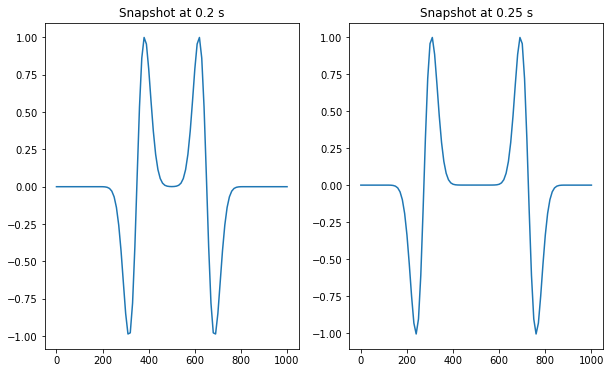

In [36]:
##  1. Preprocess of data
nx = 100
dx = 10.0
x_max = nx * dx
xx = np.arange(nx+1)*dx
xx = xx.reshape(-1, 1)

dt = 0.001
nt1 = 200
nt2 = 250
t1 = nt1 * dt 
t2 = nt2 * dt
t_total = 0.6 # total time for PDE training
wavefields = np.loadtxt('wavefields.txt')


# Input and output data
X_init1 = np.concatenate((xx, 0.0*np.ones((nx+1, 1), dtype=np.float64)), axis=1)
X_init2 = np.concatenate((xx, (t2-t1)*np.ones((nx+1, 1), dtype=np.float64)), axis=1)
snapshot1 = wavefields[nt1, :].reshape(-1, 1)
snapshot2 = wavefields[nt2, :].reshape(-1, 1)
uscl = 1/22075 # Scale the output data to [-1, 1]
U_init1 = snapshot1 / uscl
U_init2 = snapshot2 / uscl

# Plot the snapshots
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(xx, U_init1)
ax[0].set_title(f'Snapshot at {t1} s')
ax[1].plot(xx, U_init2)
ax[1].set_title(f'Snapshot at {t2} s')
plt.show()

In [34]:
# Convert to tensor
X_init1 = torch.tensor(X_init1, requires_grad=True, dtype=torch.float64, device=device)
X_init2 = torch.tensor(X_init2, requires_grad=True, dtype=torch.float64, device=device)
U_init1 = torch.tensor(U_init1, dtype=torch.float64, device=device)
U_init2 = torch.tensor(U_init2, dtype=torch.float64, device=device)

We have to scale the PDE to constrain the wavespeed in $[0, 1]$, let $L_x$ to be the scale factor, $x = x^{*}L_x$, then
$$ \frac{d}{dx^{*}} = \frac{d}{dx}\frac{dx}{dx^{*}} = L_x\frac{d}{dx}$$
so 
$$ \frac{d^2}{dx^{*2}} = \frac{d}{dx^*}L_x\frac{d}{dx} = L^2_x\frac{d}{dx^2}$$
Substituding into the equation:
$$u_{tt} - v^{*2}u_{x^*x^*} = 0$$
in which
$$ v^* = \frac{v}{L_x}$$

In [41]:
Lx = 1500.0
normalization_factor = np.array([x_max/Lx, t_total-t1]).reshape(-1, 1).T
normalization_factor = torch.tensor(normalization_factor, dtype=torch.float64, device=device)

In [42]:
# collocation points
n_pde = 20000
def samplePDE():
    X_pde = sobol_sequence.sample(n_pde+1, 2)[1:, :]
    X_pde[:, 0] = X_pde[:, 0] * x_max / Lx
    X_pde[:, 1] = X_pde[:, 1] * (t_total - t1)
    X_pde = torch.tensor(X_pde, dtype=torch.float64, requires_grad=True, device=device)
    return X_pde

In [ ]:
## 2. Model (structure of neural networks)
